In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from scipy import linalg as LA
import random
import numpy.matlib
import kwant
import tinyarray
import multiprocessing as mp
import os
from tqdm import tqdm
import helpers as hp


In [2]:
####### System Parameters

t = 102.0
mu = 1
mu_n = 0.2
mu_leads = 20.0
Delta = 0.5
alpha = 3.5
Ln = 20 # normal metal length
Lb = 4 #barrier length
Ls = 500 #super conductor length
V_c = np.sqrt(mu**2 + Delta**2)
V_z = 0.5* V_c # To generate Fig 2a V_z should be varied. For the cyan line in Fig 2, for example, V_z = 1.203 * V_c  
barrier0 = 5

points = 100 #number of points for varying conductance at either lead
num_engs = 100 #number of points in dIdV energy sweep to get ZBP

barrier_arr = np.linspace(0, 40*barrier0, points) #Varying the right barrier U_R and lef barrier U_L

In [4]:
Vz_var = np.linspace(0.5, 1.5, 1) #vary Vz by factors of the critical field V_c
energies = np.linspace(-0.5, 0.5, num_engs)
dIdVs_left_arr = np.zeros(shape = (len(Vz_var), len(energies)))
dIdVs_right_arr = np.zeros(shape = (len(Vz_var), len(energies)))
ldos_arr = np.zeros(shape = (len(Vz_var), len(energies), 2192)) #last index is the length of a single ldos. Checked it by running kwant.ldos on the system

Tinvs_left = np.zeros_like(Vz_var) #array for "topological invariant" measured by varying the left barrier
Tinvs_right = np.zeros_like(Vz_var) #array for "topological invariant" measured by varying the right barrier


barrier_right_conductance_left_arr  = np.zeros(shape=(len(Vz_var), points))
barrier_right_conductance_right_arr = np.zeros_like(barrier_right_conductance_left_arr)
barrier_left_conductance_left_arr   = np.zeros_like(barrier_right_conductance_left_arr)
barrier_left_conductance_right_arr  = np.zeros_like(barrier_right_conductance_left_arr)


for i in range(len(Vz_var)):
    vzvar = Vz_var[i] * V_c
    
    print(f"Running Vzvar {i}/{len(Vz_var)}  Value: ({ Vz_var[i]} * V_c) ------------------------------------------------------")
    #calculate dIdV with system with symmetric barrier (left and right should be the same for this case)
    syst = hp.build_system(t=t, mu=mu, mu_n=mu_n, Delta=Delta, V_z=vzvar, alpha=alpha, Ln=Ln, Lb=Lb, Ls=Ls, mu_leads=mu_leads, barrier_l=barrier0, barrier_r=barrier0)
    dIdVl, dIdVr, ldos = hp.calc_dIdV(syst, energies)
    
    dIdVs_left_arr[i, :] = dIdVl
    dIdVs_right_arr[i, :] = dIdVr
    
    # varying right barrier
    barrier_right_conductance_left = np.zeros(points)
    barrier_right_conductance_right = np.zeros(points)

    # varying left barrier
    barrier_left_conductance_left = np.zeros(points)
    barrier_left_conductance_right = np.zeros(points)

    for k in tqdm(range(points), desc = f"Calculating Conductances for Vzvar {i}/{len(Vz_var)}"):
        #print(f"running point: {k}/{points}")
        syst_UR = hp.build_system(t=t, mu=mu, mu_n=mu_n, Delta=Delta, V_z=vzvar, alpha=alpha, Ln=Ln, Lb=Lb, Ls=Ls, mu_leads=mu_leads, barrier_l=barrier0, barrier_r=barrier_arr[k])
        syst_UL = hp.build_system(t=t, mu=mu, mu_n=mu_n, Delta=Delta, V_z=vzvar, alpha=alpha, Ln=Ln, Lb=Lb, Ls=Ls, mu_leads=mu_leads, barrier_l=barrier_arr[k], barrier_r=barrier0)

        #Calculating the conductance varying UR
        cL, cR = hp.calc_conductance(syst_UR, energy=0.0)
        barrier_right_conductance_left[k] = cL
        barrier_right_conductance_right[k] = cR
        
        #Calculating the conductance varying UR
        cL, cR = hp.calc_conductance(syst_UL, energy=0.0)
        barrier_left_conductance_left[k] = cL
        barrier_left_conductance_right[k] = cR
    
    barrier_right_conductance_left_arr[i,:]= barrier_right_conductance_left
    barrier_right_conductance_right_arr[i,:]= barrier_right_conductance_right
    
    barrier_left_conductance_left_arr[i, :] = barrier_left_conductance_left
    barrier_left_conductance_right_arr[i, :] = barrier_left_conductance_right
    
    Tinvs_left[i] = hp.calc_integrated_area_diff(barrier_left_conductance_left, barrier_left_conductance_right)
    Tinvs_right[i] = hp.calc_integrated_area_diff(barrier_right_conductance_left, barrier_right_conductance_right)
    
    print("\n")
    
    
        
dirname = "testdir2"
hp.np_save_wrapped(energies, "energies", dirname)

hp.np_save_wrapped(dIdVs_left_arr, "dIdVs_left_arr", dirname)
hp.np_save_wrapped(dIdVs_right_arr, "dIdVs_right_arr", dirname)

hp.np_save_wrapped(ldos_arr, "LDOS", dirname)

hp.np_save_wrapped(barrier_right_conductance_left_arr, "barrier_right_conductance_left_arr", dirname)
hp.np_save_wrapped(barrier_right_conductance_right_arr, "barrier_right_conductance_right_arr", dirname)    
hp.np_save_wrapped(barrier_left_conductance_left_arr, "barrier_left_conductance_left_arr", dirname)    
hp.np_save_wrapped(barrier_left_conductance_right_arr, "barrier_left_conductance_right_arr", dirname)

hp.np_save_wrapped(Tinvs_left, "Tinvs_left", dirname)
hp.np_save_wrapped(Tinvs_right, "Tinvs_right", dirname)
    
    

Running Vzvar 0/1  Value: (0.5 * V_c) ------------------------------------------------------


Calculating Conductances for Vzvar 0/1: 100%|██████████| 100/100 [00:41<00:00,  2.42it/s]

In [7]:
#To generate Figs 1 and 2 one first sets the parameters


# varying right barrier
barrier_right_conductance_left = np.zeros(points)
barrier_right_conductance_right = np.zeros(points)

# varying left barrier
barrier_left_conductance_left = np.zeros(points)
barrier_left_conductance_right = np.zeros(points)

for k in tqdm(range(points), desc = "Calculating Conductance with barrier variations"):
    #print(f"running point: {k}/{points}")
    syst_UR = hp.build_system(t=t, mu=mu, mu_n=mu_n, Delta=Delta, V_z=V_z, alpha=alpha, Ln=Ln, Lb=Lb, Ls=Ls, mu_leads=mu_leads, barrier_l=barrier0, barrier_r=barrier_arr[k])
    syst_UL = hp.build_system(t=t, mu=mu, mu_n=mu_n, Delta=Delta, V_z=V_z, alpha=alpha, Ln=Ln, Lb=Lb, Ls=Ls, mu_leads=mu_leads, barrier_l=barrier_arr[k], barrier_r=barrier0)
    
    #Calculating the conductance varying UL and UR

    cL, cR = hp.calc_conductance(syst_UR, energy=0.0)
    barrier_right_conductance_left[k] = cL
    barrier_right_conductance_right[k] = cR
    
    cL, cR = hp.calc_conductance(syst_UR, energy=0.0)
    barrier_left_conductance_left[k] = cL
    barrier_left_conductance_right[k] = cR
    

Calculating Conductance with barrier variations: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


In [12]:
#plt.plot(barrier_arr/barrier0,barrier_right_conductance_left/barrier_right_conductance_left[0])
#plt.plot(barrier_arr/barrier0,barrier_left_conductance_left/barrier_left_conductance_left[0])

In [9]:
### calculating ZBP using kwant
num_engs = 100
energies = np.linspace(-0.5, 0.5, num_engs)
dIdV_left = np.zeros_like(energies)
dIdV_right = np.zeros_like(energies)
ldos = np.zeros(shape = (num_engs, 2192))
#using symmetric barrier for now
syst = hp.build_system(t=t, mu=mu, mu_n=mu_n, Delta=Delta, V_z=V_z, alpha=alpha, Ln=Ln, Lb=Lb, Ls=Ls, mu_leads=mu_leads, barrier_l=barrier0, barrier_r=barrier0)

dIdV_left, dIdV_right, ldos = hp.calc_dIdV(syst, energies)
    
    
   

Calculating dI/dV: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


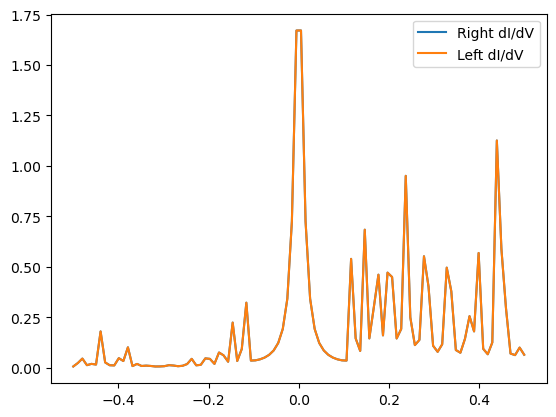

In [10]:
plt.plot(energies, dIdV_right, label = "Right dI/dV")
plt.plot(energies, dIdV_left, label = "Left dI/dV")
plt.legend()
    
    

ValueError: 'locs' must be 1D with shape (M,). Your input has shape (3, 200).

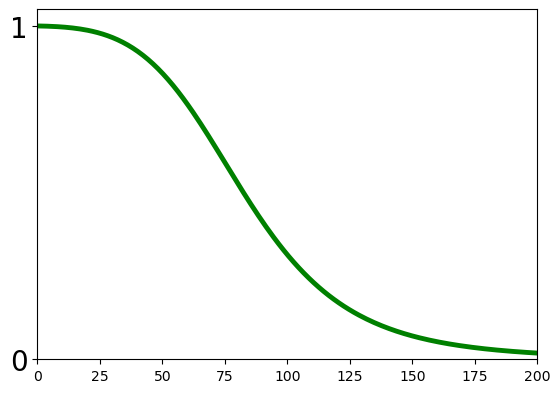

In [ ]:
# This can be used to plot the many cases explored in Figs 1 and 2. 
# For Figs. 2a and 2b, one just needs to change the variables accordingly, barrier_r -> V_z and instead of the conductance 
# plot the Andreev reflection components calculated above

fig, axes = plt.subplots(1,1, figsize=(5,3.5))
fig.subplots_adjust(0,0,1,1)

lw = 3.5

axes.plot(barrier_arr, barrier_right_conductance_left/barrier_right_conductance_left[0], color="green", linewidth=lw)
axes.set_xlim(barrier_arr[0], barrier_arr[-1])
axes.set_ylim(0, 1.05)
axes.set_yticks([0, 1])
axes.set_yticklabels([0, 1], fontsize=20)
axes.set_xticks([barrier_l, 15*barrier_l, 30*barrier_l])
axes.set_xticklabels([1, 15, 30], fontsize=20)
axes.set_xlabel(r"$U_{R}/U_{L} $", fontsize=20)
axes.set_ylabel(r"$G_{LL}/G_{LL, sym}$", fontsize=22)
axes.yaxis.set_label_coords(-0.01, 0.5)

fig, axes = plt.subplots(1,1, figsize=(5,3.5))
fig.subplots_adjust(0,0,1,1)

axes.plot(barrier_r, conductance_right/conductance_right[0], color="green", linewidth=lw)
axes.set_xlim(barrier_r[0], barrier_r[-1])
axes.set_ylim(0, 1.05)
axes.set_yticks([0, 1])
axes.set_yticklabels([0, 1], fontsize=20)
axes.set_xticks([barrier_l, 15*barrier_l, 30*barrier_l])
axes.set_xticklabels([1, 15, 30], fontsize=20)
axes.set_xlabel(r"$U_{R}/U_{L}$", fontsize=20)
axes.set_ylabel(r"$G_{RR}/G_{RR, sym}$", fontsize=22)
axes.yaxis.set_label_coords(-0.01, 0.5)

PosixPath('/home/pseudonym/code/Nonlocal_Conductance/Nonlocality-of-local-Andreev-conductances-as-a-probe-for-topological-Majorana-wires/Data')